<a href="https://colab.research.google.com/github/emiletimothy/Caltech-CS155-2023/blob/main/set4/prob2_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns

In [10]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


# Part A: Data Setup

In [53]:
# data preprocessing
df = pd.read_csv("data/COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")

# Get rid of rows where death_yn isn't Yes or No
df = df[df["death_yn"].isin(["Yes", "No"])]

# Make X of features converted into numbers, using one-hot encoding
X = np.column_stack([
    (df['sex'] == "Male").astype(int),
    (df["current_status"] == "Laboratory-confirmed case").astype(int),
    pd.get_dummies(df["age_group"]),
    pd.get_dummies(df["race_ethnicity_combined"]),
    (df["hosp_yn"] == "Yes").astype(int),
    (df["icu_yn"] == "Yes").astype(int),
    (df["medcond_yn"] == "Yes").astype(int),
])

# Make Y of death_yn converted to 0 or 1
Y = np.column_stack([(df["death_yn"] == "Yes").astype(int)])

print(X.shape, Y.shape)

(259715, 24) (259715, 1)


In [54]:
# Use 80% of data for training, 20% for testing
train_cutoff = int(len(X) * 0.8)

train_X = torch.tensor(X[:train_cutoff], dtype=torch.float32)
train_y = torch.tensor(Y[:train_cutoff], dtype=torch.float32)

test_X = torch.tensor(X[train_cutoff:], dtype=torch.float32)
test_y = torch.tensor(Y[train_cutoff:], dtype=torch.float32)


# make datasets and dataloaders

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 


# Part B: Linear Neural Network

## Model Setup

In [93]:
# TODO: Make your model, optmizer, and loss function here.

model = nn.Sequential(
    nn.Linear(X.shape[1], 5),
    nn.Linear(5, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

## Training Loop

In [94]:
# Some layers, such as Dropout, behave differently during training

model.train()

for epoch in range(1):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

## Testing Loop

In [99]:
# Putting layers like Dropout into evaluation mode
model.eval()

train_loss = 0
correct = 0

with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        train_loss += loss_fn(output, target).item()
        pred = output.round()
        correct += pred.eq(target.view_as(pred)).sum().item()

train_loss /= len(train_loader.dataset)

print(f"Train loss: {train_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({100. * correct / len(train_loader.dataset):.0f}%)")

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()
        pred = output.round()
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print(f"Test loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")

Train loss: 0.0023, Accuracy: 202487/207772 (97%)
Test loss: 0.0024, Accuracy: 50567/51943 (97%)


## Weight Matrix Visualization

<AxesSubplot:>

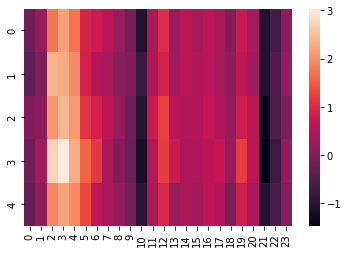

In [90]:
weights = model.state_dict()['0.weight']

sns.heatmap(weights)

# Part C: 2-Layer Linear Model

In [92]:
# TODO: Repeat for 2-layer model
model = nn.Sequential(
    nn.Linear(X.shape[1], 5),
    nn.Linear(5, 5),
    nn.Linear(5, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

print("Training")
model.train()

for epoch in range(1):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

print("Testing")
model.eval()

train_loss = 0
correct = 0

with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        train_loss += loss_fn(output, target).item()
        pred = output.round()
        correct += pred.eq(target.view_as(pred)).sum().item()

train_loss /= len(train_loader.dataset)

print(f"Train loss: {train_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({100. * correct / len(train_loader.dataset):.0f}%)")

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()
        pred = output.round()
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print(f"Test loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")

Training
Testing
Train loss: 0.0023, Accuracy: 202497/207772 (97%)
Test loss: 0.0024, Accuracy: 50560/51943 (97%)
